<small>
!/usr/bin/env python
 coding: utf-8

Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on where you have them in commands.  
   - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.
 

You can download the data set with this command line (or just a browser):
 
`wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz `</small>


In [ ]:
def in_notebook():
  """
  Test if we are in a python script vs jupyter notebook.
  Returns True if called in a jupyter notebook, false if called in a standard python file
  taken from https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
  """
  import __main__ as main
  return not hasattr(main, '__file__')

In [251]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers, models
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

# if in_notebook:
#   from tqdm.notebook import tqdm
# else:
#   from tqdm import tqdm 

import os
import pathlib

from datetime import datetime as dt

from IPython import display

import platform

2.10.0


In [ ]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# Define range of 16-bit integers
i16min = -2**15
i16max = 2**15-1
fsamp = 16000 # sampling rate
wave_length_ms = 1000 # 1000 => 1 sec of audio
wave_length_samps = int(wave_length_ms*fsamp/1000)

# you can change these next three
window_size_ms = 60 
window_step_ms = 40
num_filters = 32
batch_size = 64
use_microfrontend = True # recommended, but you can use another feature extractor if you like

## uncomment exactly one of these 
dataset = 'mini-speech'
# dataset = 'full-speech-files' # use the full speech commands stored as files 

commands = ['imposter', 'down'] ## Change this line for your custom keywords

silence_str = "_silence"  # label for <no speech detected>
unknown_str = "_unknown"  # label for <speech detected but not one of the target words>
EPOCHS = 50

print(f"FFT window length = {int(window_size_ms * fsamp / 1000)}")

might_be = {True:"IS", False:"IS NOT"} # useful for formatting conditional sentences

In [ ]:
if dataset == 'mini-speech':
  data_dir = pathlib.Path(os.path.join(os.getenv("USERPROFILE"), 'Desktop/UNCC/Github/ML-for-IoT/data/mini_speech_commands'))
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data')
elif dataset == 'full-speech-files':
  # data_dir = '/dfs/org/Holleman-Coursework/data/speech_dataset'
  data_dir = pathlib.Path(os.path.join(os.getenv("USERPROFILE"), 'Desktop/UNCC/Github/ML-for-IoT/data', 'speech_commands_files_0.2'))
else:
  raise RuntimeError('dataset should either be "mini-speech" or "full-speech-files"')

In [ ]:
print(data_dir)

In [ ]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

all_commands = os.listdir(data_dir)
all_commands = [c for c in all_commands if c != "README.md"]

target_commands = [c for c in all_commands if c in commands]
other_commands = [c for c in all_commands if c not in commands]

In [ ]:
if dataset == 'mini-speech' or dataset == 'full-speech-files':
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
    # with the next commented-out line, you can choose only files for words in label_list
    # filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
    # filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    print('Examples per target label:', [cmd + ': ' + str(len(tf.io.gfile.listdir(str(data_dir/cmd)))) for cmd in all_commands])
    # print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    # print('Example file tensor:', filenames[0])

In [ ]:
max_samples_per_command = int(num_samples / len(all_commands))
max_samples_per_unknown = int(max_samples_per_command / len(other_commands))

print(f"Max samples per target command = {max_samples_per_command} samples")
print(f"Max samples per other command = {max_samples_per_unknown} samples for {len(other_commands)} total classes")

samples_per_command = {}
for cmd in all_commands:
    if cmd in target_commands:
        samples_per_command[cmd] = max_samples_per_command
    elif cmd in other_commands:
        samples_per_command[cmd] = max_samples_per_unknown

print(f"Samples per command = {samples_per_command}")

In [ ]:
balanced_filenames = []
for filename in filenames:
    cmd = os.path.basename(os.path.dirname(filename))
    if samples_per_command[cmd] > 0:
        balanced_filenames.append(filename)
        samples_per_command[cmd] -= 1

filenames = tf.constant(balanced_filenames)
filenames = tf.random.shuffle(filenames)

num_samples = len(filenames)
print(f'Number of total examples after balancing', num_samples)

In [ ]:
count_filenames = [f.decode('utf-8') for f in filenames.numpy()]

examples_per_label = {}
for filename in count_filenames:
    cmd = os.path.basename(os.path.dirname(filename))
    examples_per_label[cmd] = examples_per_label.get(cmd, 0) + 1

# Print number of examples per label
for cmd, count in examples_per_label.items():
    print(f"Number of examples for label '{cmd}': {count}")

In [ ]:
if dataset == 'mini-speech':
  print('Using mini-speech')
  num_train_files = int(0.8*num_samples) 
  num_val_files = int(0.1*num_samples) 
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
elif dataset == 'full-speech-files':  
  # the full speech-commands set lists which files are to be used
  # as test and validation data; train with everything else
  fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
  with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
  # validation_list.txt only lists partial paths
  val_files = [os.path.join(data_dir, fn) for fn in val_files]
  fname_test_files = os.path.join(data_dir, 'testing_list.txt')

  with open(fname_test_files) as fpi_tst:
    test_files = fpi_tst.read().splitlines()
  # testing_list.txt only lists partial paths
  test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    

  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
  train_files = [f.decode('utf8') for f in filenames.numpy()]
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
  # train_files = [f for f in train_files if f.split('/')[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
  train_files = list(set(train_files) - set(test_files) - set(val_files))
  # now convert back into a TF tensor so we can use the tf.dataset pipeline
  train_files = tf.constant(train_files)    
  print("full-speech-files is in progress.  Good luck!")
elif dataset == 'full-speech-ds':  
    print("Using full-speech-ds. This is in progress.  Good luck!")
else:
  raise ValueError("dataset must be either full-speech-files, full-speech-ds or mini-speech")
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label # parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram

# Function to convert each waveform in a set into a spectrogram, then convert those
# back into a dataset using `from_tensor_slices`.  (We should be able to use 
# `wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).

In [ ]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [ ]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

In [ ]:
import matplotlib.pyplot as plt

# Create a dictionary where the keys are labels and the values are lists of waveforms
waveforms_by_label = {}
for audio, label in waveform_ds:
    label_str = label.numpy().decode('utf-8')
    if label_str not in waveforms_by_label:
        waveforms_by_label[label_str] = []
    if len(waveforms_by_label[label_str]) < 3:
        waveforms_by_label[label_str].append(audio.numpy())

# Determine the number of rows and columns for the plot
num_labels = len(waveforms_by_label)
rows = num_labels
cols = 3  # We want to display 3 examples for each label

# Create the plot
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (label, waveforms) in enumerate(waveforms_by_label.items()):
    for j in range(3):
        ax = axes[i][j]
        ax.plot(waveforms[j])
        ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
        ax.set_title(label)

plt.show()

In [ ]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [ ]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [ ]:
def count_labels(dataset):
    counts = {}
    for sample in dataset: # sample will be a tuple: (input, label) or (input, label, weight)
        lbl = sample[1]
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [ ]:
def is_batched(ds):
    ## This is probably not very robust
    try:
        ds.unbatch()  # does not actually change ds. For that we would ds=ds.unbatch()
    except:
        return False # we'll assume that the error on unbatching is because the ds is not batched.
    else:
        return True  # if we were able to unbatch it then it must have been batched (??)

In [ ]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(0.3*len(files))+1
  print(f"\nProcessing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)

# Print the size of the dataset before applying noisy_reps_of_known
  print(f"Size of the dataset before applying noisy_reps_of_known: {len(list(waveform_ds))}")

  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
      waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  
  print(f"Size of the dataset after applying noisy_reps_of_known: {len(list(waveform_ds))}")

  if num_silent > 0:
    # silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
    #                                         rms_noise_range=[0.01,0.2], 
    #                                         silent_label=silence_str)
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  print('\n')
  return output_ds

In [ ]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

In [ ]:
if tf.test.is_gpu_available():
    device_name = '/GPU:0'
    print('Running on GPU')
else:
    device_name = '/CPU:0'
    print('Running on CPU')

with tf.device(device_name):
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
    val_ds = preprocess_dataset(val_files)
    test_ds = preprocess_dataset(test_files)

In [ ]:
print("Training data set")
print(count_labels(train_ds))
print("Validation data set")
print(count_labels(val_ds))
print("Test data set")
print(count_labels(test_ds))

In [ ]:
train_ds = train_ds.shuffle(int(len(train_files)*4))
val_ds = val_ds.shuffle(int(len(val_files)*1.2)+1)
test_ds = test_ds.shuffle(int(len(test_files)*1.2)+1)

train_counts = count_labels(train_ds)
valid_counts = count_labels(val_ds)
test_counts = count_labels(test_ds)

In [ ]:
if not is_batched(train_ds):
    train_ds = train_ds.batch(batch_size)
if not is_batched(val_ds):
    val_ds = val_ds.batch(batch_size)
if not is_batched(test_ds):
    test_ds = test_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [254]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram.shape[1:]  
print('Input shape:', input_shape)
num_labels = len(label_list)

Input shape: (24, 32, 1)


In [ ]:
def ConvNetV1(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(8, 3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(16, 3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1),

        layers.Flatten(),
        layers.Dense(num_labels, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )
    return model

In [ ]:
# Experimenting with the model
def ConvNetV2(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(8, 3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(16, 3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1),

        layers.Flatten(),
        layers.Dense(num_labels, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )
    return model

In [ ]:
# Baseline Model
def ConvNetV3(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(8, 3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(16, 3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Conv2D(32, 3),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        layers.Flatten(),
        layers.Dense(num_labels, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )
    return model

In [261]:
def LSTMNet(input_shape, num_labels):
    model = tf.keras.models.Sequential([
        # TimeDistributed layer to process each time slice of the spectrogram
        tf.keras.layers.Reshape((-1, 1), input_shape=input_shape),

        # LSTM layers
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),

        # Output layer
        layers.Dense(num_labels, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )
    return model

In [264]:
model = ConvNetV1(input_shape, num_labels)

# model2 = ConvNetV2(input_shape, num_labels)
# model3 = ConvNetV3(input_shape, num_labels)

# model = LSTMNet(input_shape, num_labels)

history  = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS)

# print("\n\nModel 2")
# history2 = model2.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS)

# print("\n\nModel 3")
# history3 = model3.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS)

In [266]:
from keras_flops import get_flops
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)
model.summary()

flops = get_flops(model, batch_size=64)
print(f"FLOPS: {flops / 10 ** 6:.03} M")

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 22, 30, 8)         80        
                                                                 
 batch_normalization_21 (Bat  (None, 22, 30, 8)        32        
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 22, 30, 8)         0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 11, 15, 8)        0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 11, 15, 8)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 9, 13, 16)       

In [ ]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
print(f"Completed training at {date_str}")

In [ ]:
model_file_name = f"model.h5" 
print(f"Saving model to {model_file_name}")
model.save(model_file_name, overwrite=True)

In [267]:
def evaluate_model(model, test_ds):
    test_audio = []
    test_labels = []
    if is_batched(test_ds):
        was_batched=True
        test_ds = test_ds.unbatch()
    else:
        was_batched=False
    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)
    
    model_out = model.predict(test_audio)

    y_pred = np.argmax(model_out, axis=1)
    y_true = test_labels

    test_acc = sum(y_pred == y_true) / len(y_true)
    print(f'Test set accuracy: {test_acc:.1%}')
    if was_batched:
        test_ds = test_ds.batch(32)
        
    return y_pred, y_true, test_acc

y_pred, y_true, test_acc = evaluate_model(model, test_ds)
y_pred2, y_true2, test_acc2 = evaluate_model(model2, test_ds)
y_pred3, y_true3, test_acc3 = evaluate_model(model3, test_ds)

13/13 [==============================] - 0s 3ms/step
Test set accuracy: 94.1%
13/13 [==============================] - 0s 3ms/step
Test set accuracy: 80.3%
13/13 [==============================] - 0s 3ms/step
Test set accuracy: 88.0%


Text(45.581597222222214, 0.5, 'Label')

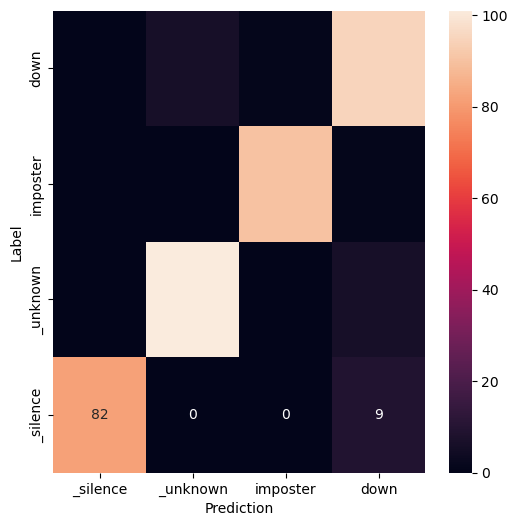

In [253]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')

In [238]:
tpr = np.nan*np.zeros(len(label_list))
fpr = np.nan*np.zeros(len(label_list))
fnr = np.nan*np.zeros(len(label_list))

for i in range(4):
    tpr[i]  = confusion_mtx[i,i] / np.sum(confusion_mtx[i,:])
    fpr[i] = (np.sum(confusion_mtx[:,i]) - confusion_mtx[i,i]) / (np.sum(confusion_mtx) - np.sum(confusion_mtx[i,:]))
    fnr[i]  = (np.sum(confusion_mtx[i,:]) - confusion_mtx[i,i]) / np.sum(confusion_mtx[i,:])
    print(f"True/False positive rate for '{label_list[i]}' = {tpr[i]:.3} / {fpr[i]:.3}")
    print(f"     False Rejection Rate for '{label_list[i]}' = {fnr[i]:.6}")

True/False positive rate for '_silence' = 0.901 / 0.0
     False Rejection Rate for '_silence' = 0.0989011
True/False positive rate for '_unknown' = 0.944 / 0.0211
     False Rejection Rate for '_unknown' = 0.0560748
True/False positive rate for 'imposter' = 0.989 / 0.00333
     False Rejection Rate for 'imposter' = 0.010989
True/False positive rate for 'down' = 0.931 / 0.0554
     False Rejection Rate for 'down' = 0.0686275


In [239]:
# confusion_mtx2 = tf.math.confusion_matrix(y_true2, y_pred2)

# plt.figure(figsize=(6, 6))
# sns.heatmap(confusion_mtx2, xticklabels=label_list, yticklabels=label_list, 
#             annot=True, fmt='g')
# plt.gca().invert_yaxis() # flip so origin is at bottom left
# plt.xlabel('Prediction')
# plt.ylabel('Label')

In [240]:
# tpr2 = np.nan*np.zeros(len(label_list))
# fpr2 = np.nan*np.zeros(len(label_list))
# fnr2 = np.nan*np.zeros(len(label_list))

# for i in range(4):
#     tpr2[i]  = confusion_mtx2[i,i] / np.sum(confusion_mtx2[i,:])
#     fpr2[i] = (np.sum(confusion_mtx2[:,i]) - confusion_mtx2[i,i]) / (np.sum(confusion_mtx2) - np.sum(confusion_mtx2[i,:]))
#     fnr2[i]  = (np.sum(confusion_mtx2[i,:]) - confusion_mtx2[i,i]) / np.sum(confusion_mtx2[i,:])
#     print(f"True/False positive rate for '{label_list[i]:9}' = {tpr2[i]:.3} / {fpr2[i]:.3}")
#     print(f"False Rejection Rate for '{label_list[i]:9}' = {fnr2[i]:.3}")

In [241]:
# confusion_mtx3 = tf.math.confusion_matrix(y_true3, y_pred3)

# plt.figure(figsize=(6, 6))
# sns.heatmap(confusion_mtx3, xticklabels=label_list, yticklabels=label_list, 
#             annot=True, fmt='g')
# plt.gca().invert_yaxis() # flip so origin is at bottom left
# plt.xlabel('Prediction')
# plt.ylabel('Label')

In [242]:
# tpr3 = np.nan*np.zeros(len(label_list))
# fpr3 = np.nan*np.zeros(len(label_list))
# fnr3 = np.nan*np.zeros(len(label_list))

# for i in range(4):
#     tpr3[i]  = confusion_mtx3[i,i] / np.sum(confusion_mtx3[i,:])
#     fpr3[i] = (np.sum(confusion_mtx3[:,i]) - confusion_mtx3[i,i]) / (np.sum(confusion_mtx3) - np.sum(confusion_mtx3[i,:]))
#     fnr3[i]  = (np.sum(confusion_mtx3[i,:]) - confusion_mtx3[i,i]) / np.sum(confusion_mtx3[i,:])
#     print(f"True/False positive rate for '{label_list[i]:9}' = {tpr3[i]:.3} / {fpr3[i]:.3}")
#     print(f"False Rejection Rate for '{label_list[i]:9}' = {fnr3[i]:.3}")

In [243]:
info_file_name = model_file_name.split('.')[0] + '.txt'
with open(info_file_name, 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")
    fpo.write(f"Test set accuracy =  {test_acc:.1%}\n")
    for i in range(4):
        fpo.write(f"tpr_{label_list[i]:9} = {tpr[i]:.3}\n")
        fpo.write(f"fpr_{label_list[i]:9} = {fpr[i]:.3}\n")

In [244]:
print(f"Wrote description to {info_file_name}")

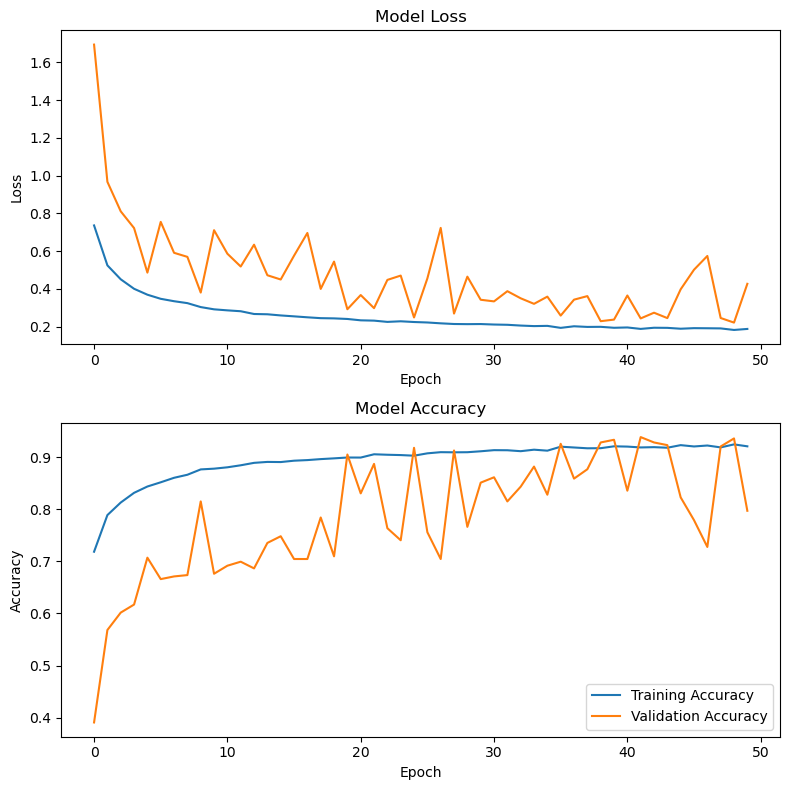

In [245]:
metrics = history.history

plt.figure(figsize=(8, 8))

# Plot training & validation loss values for all models
plt.subplot(2, 1, 1)
plt.plot(history.epoch, metrics['loss'], label='Training Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot training & validation accuracy values for all models
plt.subplot(2, 1, 2)
plt.plot(history.epoch, metrics['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.tight_layout()
plt.show()

In [246]:
# metrics2 = history2.history
# metrics3 = history3.history

# fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# # Model 1
# axs[0, 0].semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
# axs[0, 0].set_title('Model 1 Loss')
# axs[0, 0].set_ylabel('Loss')
# axs[0, 0].set_xlabel('Epoch')
# axs[0, 0].legend(['training', 'validation'])

# axs[1, 0].plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
# axs[1, 0].set_title('Model 1 Accuracy')
# axs[1, 0].set_ylabel('Accuracy')
# axs[1, 0].set_xlabel('Epoch')
# axs[1, 0].legend(['training', 'validation'])

# # Model 2
# axs[0, 1].semilogy(history2.epoch, metrics2['loss'], metrics2['val_loss'])
# axs[0, 1].set_title('Model 2 Loss')
# axs[0, 1].set_ylabel('Loss')
# axs[0, 1].set_xlabel('Epoch')
# axs[0, 1].legend(['training', 'validation'])

# axs[1, 1].plot(history2.epoch, metrics2['accuracy'], metrics2['val_accuracy'])
# axs[1, 1].set_title('Model 2 Accuracy')
# axs[1, 1].set_ylabel('Accuracy')
# axs[1, 1].set_xlabel('Epoch')
# axs[1, 1].legend(['training', 'validation'])

# # Model 3
# axs[0, 2].semilogy(history3.epoch, metrics3['loss'], metrics3['val_loss'])
# axs[0, 2].set_title('Model 3 Loss')
# axs[0, 2].set_ylabel('Loss')
# axs[0, 2].set_xlabel('Epoch')
# axs[0, 2].legend(['training', 'validation'])

# axs[1, 2].plot(history3.epoch, metrics3['accuracy'], metrics3['val_accuracy'])
# axs[1, 2].set_title('Model 3 Accuracy')
# axs[1, 2].set_ylabel('Accuracy')
# axs[1, 2].set_xlabel('Epoch')
# axs[1, 2].legend(['training', 'validation'])

# plt.tight_layout()
# plt.show()

In [247]:
from keras.models import load_model
model = load_model('model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        next_input = next(ds_iter)[0]
        next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
        yield [next_input]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_quant_model = converter.convert()

file_name = 'model.tflite'

with open(file_name, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")